In [0]:
import os
from google.colab import drive, files

drive.mount('/content/drive', force_remount=True)
!ls '/content/drive/My Drive/Colab Notebooks/'

Mounted at /content/drive
'10 Year IMPLICIT RNN'
'10 Year NEXT STATE PREDICTOR'
'10 Year NEXT STATE PREDICTOR+linear model'
 colab_setup.py
'Copy of Copy of RNN_Model_Control_Input_Energy_Consumption_Output.ipynb'
'Copy of Next State Predictor'
'Copy of RNN_Model_Control_Input_Energy_Consumption_Output (1).ipynb'
'Copy of RNN_Model_Control_Input_Energy_Consumption_Output.ipynb'
 Dash
 eplusout_largeoffice_darksky_2009_2019.sql
 eplusparser
 hybrid_model_weights
 icnn_icrnn
 implicit_rnn_2019-11-11.h5
 implicit_rnn_2019-11-11_scalerU.pickle
 implicit_rnn_2019-11-11_scalerX.pickle
 implicit_rnn_2019-11-11_scalerY.pickle
 implicit_rnn_2019-11-11_y_pred.pickle
 implicit_rnn_2019-11-11_y_real.pickle
 implicit_rnn_2019-11-12.h5
 implicit_rnn_2019-11-12_scalerU.pickle
 implicit_rnn_2019-11-12_scalerX.pickle
 implicit_rnn_2019-11-12_scalerY.pickle
 implicit_rnn_2019-11-12_y_pred.csv
 implicit_rnn_2019-11-12_y_real.csv
 implicit_rnn_2019-11-23.h5
 implicit_rnn_2019-11-23_scalerU.pickle
 implici

In [0]:
!rm -rf eplusparser && git clone https://github.com/energy-plus-senior-design/eplusparser.git

%cd eplusparser
%pwd
!pip install .

Cloning into 'eplusparser'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 63 (delta 6), reused 20 (delta 6), pack-reused 43
Unpacking objects: 100% (63/63), done.
/content/eplusparser
Processing /content/eplusparser
  Created wheel for eplusparser: filename=eplusparser-0.1.3-cp36-none-any.whl size=2859 sha256=ee35993822a476086d5299663a1f76c2182eb16c110578328f698110a68829c0
  Stored in directory: /tmp/pip-ephem-wheel-cache-fmjasj83/wheels/73/df/0d/2ddf4deebbb98a075d23e60603808eec3f8acdbb19941dd6e4
Successfully built eplusparser
  Found existing installation: eplusparser 0.1.3
    Uninstalling eplusparser-0.1.3:
      Successfully uninstalled eplusparser-0.1.3


In [0]:
# -*- coding: utf-8 -*-
"""
Created on Mon Feb 18 18:50:22 2019

@author: Vivian
"""

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sqlite3
import math
import keras
import keras.backend as K
from sklearn.preprocessing import normalize
from eplusparser import parse, get_uxy
from sklearn.preprocessing import MinMaxScaler
from keras.regularizers import l2
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
import sqlite3

Using TensorFlow backend.


In [0]:
df = parse('/content/drive/My Drive/Colab Notebooks/eplusout_largeoffice_darksky_2009_2019.sql')
df.head()
dataset = df.values
names = df.columns.values.tolist()

# get u_t, x_t, y_t
u_orig_df, x_orig_df, y_orig_df = get_uxy(df)
print('u_t: ' + str(u_orig_df.head()))
print('x_t: ' + str(x_orig_df.head()))
print('y_t: ' + str(y_orig_df.head()))
u_orig = u_orig_df.values
x_orig = x_orig_df.values
y_orig = y_orig_df.values

u_t = u_orig
x_t = x_orig
y_t = y_orig

# normalize the dataset
scalerU = MinMaxScaler(feature_range=(0, 1))
scalerX = MinMaxScaler(feature_range=(0, 1))
scalerY = MinMaxScaler(feature_range=(0, 1))

# u_t = scalerU.fit_transform(u_orig)
# x_t = scalerX.fit_transform(x_orig)
# y_t = scalerY.fit_transform(y_orig)

# split into train and test sets
remove_size = int(len(u_t) * 1/11)  # remove first year
train_size = int(len(u_t) * 9/11)   # 9 years training
test_size = len(u_t) - train_size - remove_size  # 1 year testing
u_removeset, u_trainset, u_testset = u_t[0:remove_size,:], u_t[remove_size:remove_size+train_size,:], u_t[remove_size+train_size:,:]
x_removeset, x_trainset, x_testset = x_t[0:remove_size,:], x_t[remove_size:remove_size+train_size,:], x_t[remove_size+train_size:,:]
y_removeset, y_trainset, y_testset = y_t[0:remove_size,:], y_t[remove_size:remove_size+train_size,:], y_t[remove_size+train_size:,:]

print(len(u_trainset), len(u_testset))

u_t: VariableName Schedule Value               ... Zone Thermostat Heating Setpoint Temperature                   
KeyValue       ACTIVITY_SCH AIR_VELO_SCH  ...                           PERIMETER_TOP_ZN_3 PERIMETER_TOP_ZN_4
TimeIndex                                 ...                                                                
1                     120.0          0.2  ...                                         21.0               21.0
2                     120.0          0.2  ...                                         21.0               21.0
3                     120.0          0.2  ...                                         21.0               21.0
4                     120.0          0.2  ...                                         21.0               21.0
5                     120.0          0.2  ...                                         21.0               21.0

[5 rows x 124 columns]
x_t: VariableName Zone Air Humidity Ratio  ... Zone Mean Air Temperature
KeyValue          

In [0]:
def create_dataset(u_t, x_t, y_t, scalerU, scalerX, scalerY, look_back):
    dataX, dataY = [], []
    for idx in range(0, len(u_t[0])):  # iterate through columns
      for i in range(0, len(u_t[0:,idx]) - look_back - 1):  # iterate through windows
            x_window = u_t[i:(i + look_back), idx]  # get particular window
            if i >= len(dataX):
              dataX.append(x_window)
            else:
              dataX[i] = np.append(dataX[i], x_window)      
    for idx in range(0, len(y_t[0])):
      for i in range(0, len(y_t[0:,idx]) - look_back - 1):  
            y_window = y_t[i:(i + look_back), idx]  
            if i >= len(dataY):
              dataY.append(y_window)
            else:
              dataY[i] = np.append(dataY[i], y_window)  

    dataX = np.array(dataX)
    dataY = np.array(dataY)
    dataX = scalerU.fit_transform(dataX)
  #     dataY = dataY.reshape(-1, 1)
    dataY = scalerY.fit_transform(dataY)

    return dataX, dataY 

# create datasets
look_back = 1
trainX, trainY = create_dataset(u_trainset, x_trainset, y_trainset, 
                                scalerU, scalerX, scalerY, look_back)
testX, testY = create_dataset(u_testset, x_testset, y_testset, 
                              scalerU, scalerX, scalerY, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print('trainX.shape: ' + str(trainX.shape))
print('testX.shape: ' + str(testX.shape))
print('trainY.shape: ' + str(trainY.shape))
print('testY.shape: ' + str(testY.shape))

trainX.shape: (78916, 1, 124)
testX.shape: (8768, 1, 124)
trainY.shape: (78916, 2)
testY.shape: (8768, 2)


In [0]:
print('trainX')
print(trainX)
print('trainY')
print(trainY)

trainX
[[[0. 0. 0. ... 1. 1. 1.]]

 [[0. 0. 0. ... 1. 1. 1.]]

 [[0. 0. 0. ... 1. 1. 1.]]

 ...

 [[0. 0. 0. ... 1. 1. 1.]]

 [[0. 0. 0. ... 1. 1. 1.]]

 [[0. 0. 0. ... 1. 1. 1.]]]
trainY
[[0.51303798 0.4585253 ]
 [0.49016207 0.39952527]
 [0.4600494  0.3472518 ]
 ...
 [0.2458603  0.17491071]
 [0.21595547 0.15929938]
 [0.21591925 0.1478856 ]]


In [0]:
def create_model(trainX, trainY):
    model = keras.models.Sequential()
    model.add(LSTM(16, input_shape=(look_back, trainX.shape[2])))
    model.add(Dense(trainY.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
        
    return model

In [0]:
# create and fit the LSTM network
model = create_model(trainX, trainY)

In [0]:
model.fit(trainX, trainY, epochs=100, batch_size=100, verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/100





 - 3s - loss: 0.0029
Epoch 2/100
 - 2s - loss: 9.3258e-04
Epoch 3/100
 - 2s - loss: 8.0913e-04
Epoch 4/100
 - 2s - loss: 7.7166e-04
Epoch 5/100
 - 2s - loss: 7.3622e-04
Epoch 6/100
 - 2s - loss: 7.0879e-04
Epoch 7/100
 - 2s - loss: 6.8801e-04
Epoch 8/100
 - 3s - loss: 6.7107e-04
Epoch 9/100
 - 2s - loss: 6.5279e-04
Epoch 10/100
 - 3s - loss: 6.4449e-04
Epoch 11/100
 - 2s - loss: 6.3981e-04
Epoch 12/100
 - 2s - loss: 6.2995e-04
Epoch 13/100
 - 2s - loss: 6.2761e-04
Epoch 14/100
 - 2s - loss: 6.1836e-04
Epoch 15/100
 - 2s - loss: 6.1829e-04
Epoch 16/100
 - 2s - loss: 6.1327e-04
Epoch 17/100
 - 2s - loss: 6.1002e-04
Epoch 18/100
 - 2s - loss: 6.0768e-04
Epoch 19/100
 - 2s - loss: 6.0099e-04
Epoch 20/100
 - 2s - loss: 5.9759e-04
Epoch 21/100
 - 2s - loss: 5.9630e-04
Epoch 22/100
 - 2s - loss: 5.9366e-04
Epoch 23/100
 - 2s - loss: 5.9228e-04
Epoch 24/100
 - 2s - loss: 5.9137e-04

In [0]:
# make predictions
trainPredict = model.predict(trainX)
model.reset_states()
testPredict = model.predict(testX)

# calculate the scaled root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.3f RMSE' % (testScore))

Train Score: 0.024 RMSE
Test Score: 0.038 RMSE


In [0]:
# invert predictions
trainPredictInv = scalerY.inverse_transform(trainPredict)
trainYInv = scalerY.inverse_transform(trainY)
testPredictInv = scalerY.inverse_transform(testPredict)
testYInv = scalerY.inverse_transform(testY)

print('trainPredict')
print(trainPredict)
print('trainY')
print(trainY)
print('testPredict')
print(testPredict)
print('testY')
print(testY)

print('trainPredictInv')
print(trainPredictInv)
print('trainYInv')
print(trainYInv)
print('testPredictInv')
print(testPredictInv)
print('testYInv')
print(testYInv)

trainPredict
[[0.5141363  0.23675312]
 [0.4942812  0.20878343]
 [0.46450466 0.17813435]
 ...
 [0.2649893  0.12683503]
 [0.22318134 0.11503675]
 [0.22896034 0.1041164 ]]
trainY
[[0.51303798 0.4585253 ]
 [0.49016207 0.39952527]
 [0.4600494  0.3472518 ]
 ...
 [0.2458603  0.17491071]
 [0.21595547 0.15929938]
 [0.21591925 0.1478856 ]]
testPredict
[[0.06578466 0.10994152]
 [0.06045502 0.10888052]
 [0.11283693 0.12078665]
 ...
 [0.06421109 0.00291421]
 [0.06525222 0.0050576 ]
 [0.04768921 0.00420449]]
testY
[[0.06647716 0.18988867]
 [0.06651156 0.19594679]
 [0.11929154 0.20397165]
 ...
 [0.08241363 0.0714055 ]
 [0.08517234 0.08422396]
 [0.06693248 0.08007301]]
trainPredictInv
[[3.6749898e+09 2.8896264e+09]
 [3.5624179e+09 2.5482583e+09]
 [3.3935941e+09 2.1741885e+09]
 ...
 [2.2624049e+09 1.5480842e+09]
 [2.0253670e+09 1.4040870e+09]
 [2.0581321e+09 1.2708049e+09]]
trainYInv
[[3.66876271e+09 5.59633924e+09]
 [3.53906353e+09 4.87624827e+09]
 [3.36833421e+09 4.23825442e+09]
 ...
 [2.15394960e+09

In [0]:
# calculate the root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.3f RMSE' % (testScore))

Train Score: 0.024 RMSE
Test Score: 0.038 RMSE


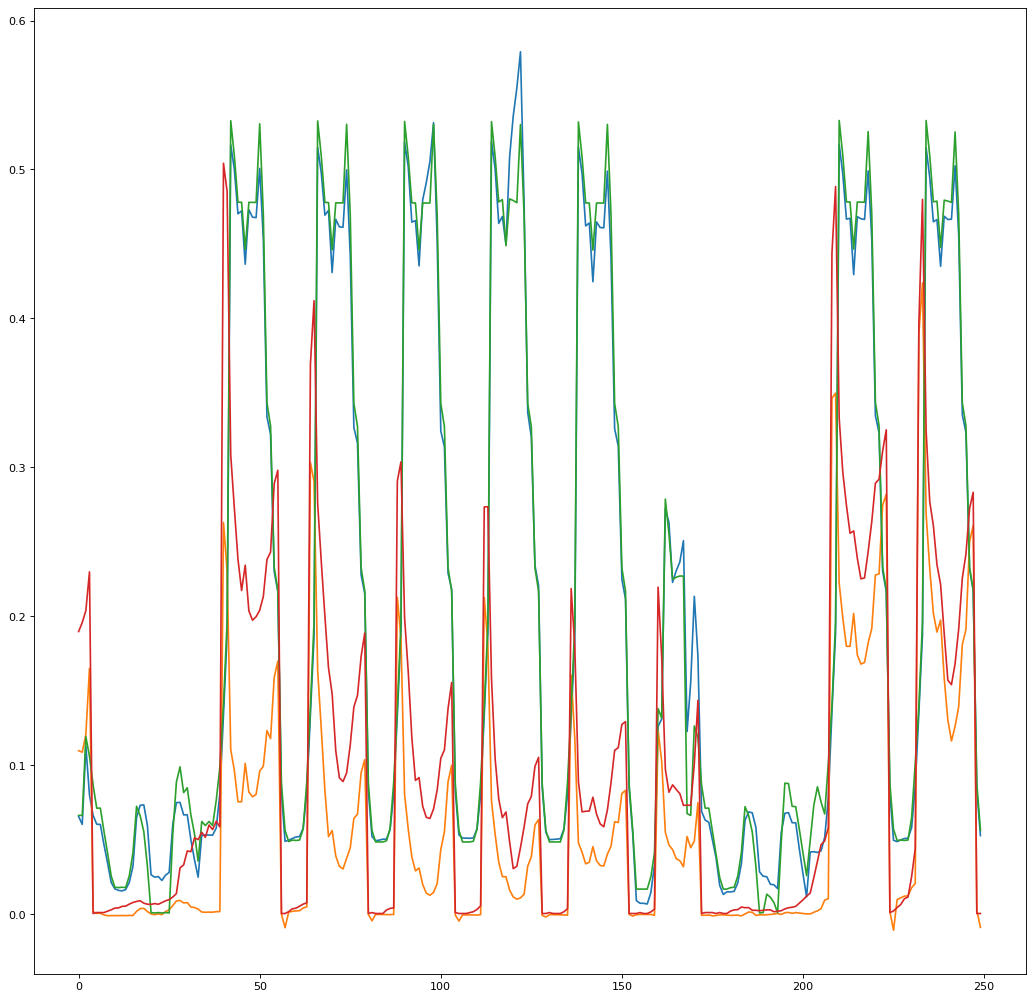

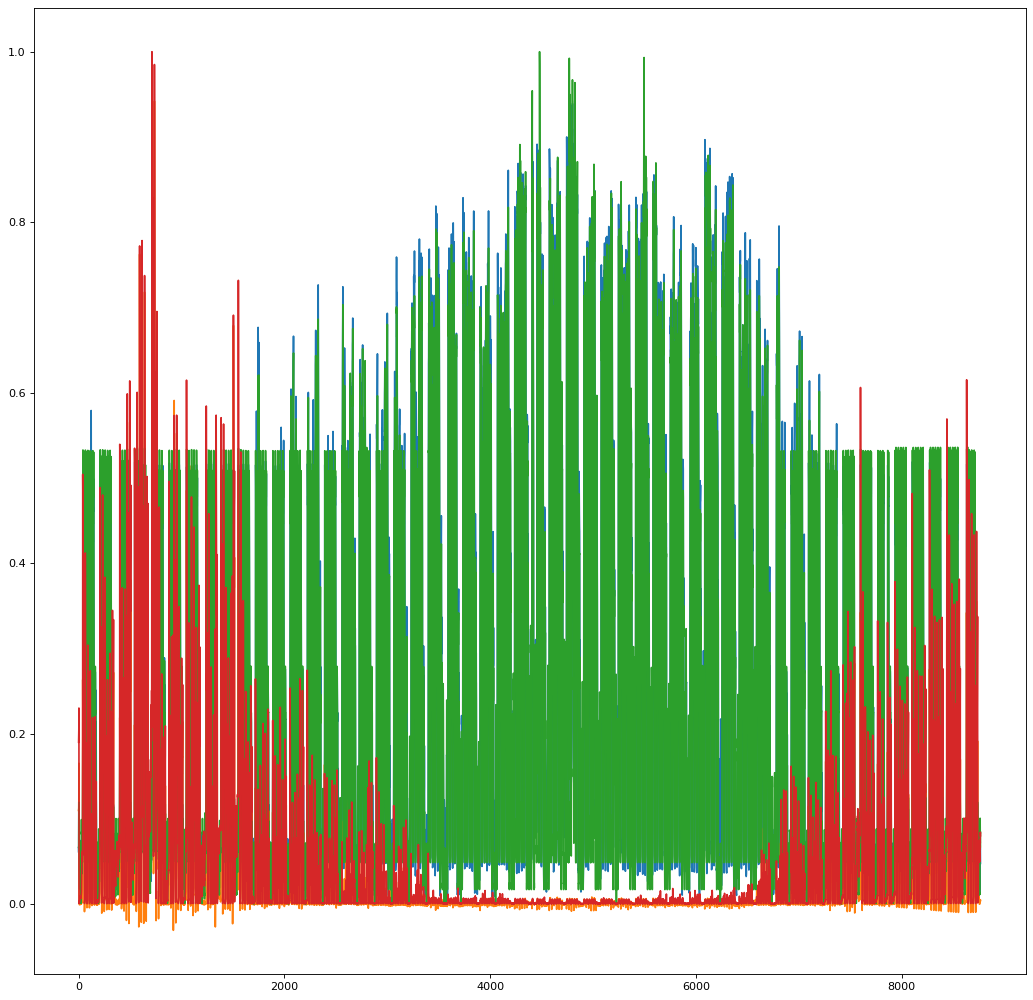

In [0]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(num=None, figsize=(16, 16), dpi=80, facecolor='w', edgecolor='k')
plt.plot(testPredict[:250])
plt.plot(testY[:250])

figure(num=None, figsize=(16, 16), dpi=80, facecolor='w', edgecolor='k')
plt.plot(testPredict)
plt.plot(testY)


In [0]:
model.save('/content/drive/My Drive/Colab Notebooks/implicit_rnn_2019-11-23.h5')  
import pickle
with open('/content/drive/My Drive/Colab Notebooks/implicit_rnn_2019-11-23_scalerU.pickle', 'wb') as f:
  pickle.dump(scalerU, f)
with open('/content/drive/My Drive/Colab Notebooks/implicit_rnn_2019-11-23_scalerX.pickle', 'wb') as f:
  pickle.dump(scalerX, f)
with open('/content/drive/My Drive/Colab Notebooks/implicit_rnn_2019-11-23_scalerY.pickle', 'wb') as f:
  pickle.dump(scalerY, f)

In [0]:
pd.DataFrame(data=testPredictInv, columns=y_orig_df.columns).to_csv('/content/drive/My Drive/Colab Notebooks/implicit_rnn_2019-11-23_y_pred.csv')
pd.DataFrame(data=testYInv, columns=y_orig_df.columns).to_csv('/content/drive/My Drive/Colab Notebooks/implicit_rnn_2019-11-23_y_real.csv')